In [1]:
# example codes from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
# Untargeted FGSM attack

# import using packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# setting parameters
epsilons = [0, .05, .1, .15, .2, .25, .3]
alpha = 2 / 255
max_iter = 15

In [3]:
# inputs
pretrained_model = "../data/lenet_mnist_model.pth"
use_cuda=True
# Set random seed for reproducibility
torch.manual_seed(42)

In [4]:
# import LeNet model

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# MNIST Test dataset and dataloader declaration
# first 1000 data points will be used for testing
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=False)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [5]:
# targeted FGSM attack
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# targeted PGD attack
def pgd_attack(model, data, data_denorm, alpha, max_iter, target, epsilon):
    # initialize perturbed image
    perturbed_image = data_denorm
    original_image = data_denorm

    data, target = data.to(device), target.to(device)
    original_image = original_image.to(device)
    data.requires_grad = True

    # iterate for max_iter
    for iter in range(max_iter):
        output = model(data)
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        data_denorm = denorm(data)
        perturbed_image = fgsm_attack(data_denorm, alpha, data_grad)
        perturbed_image = perturbed_image.to(device)

        # Clip perturbations to epsilon
        perturbed_image = torch.clamp(perturbed_image, original_image - epsilon, original_image + epsilon)

        # change data value as normalized perturbed image
        data = norm(perturbed_image).clone().detach().requires_grad_(True)
        
    data_denorm = denorm(data)
    return data_denorm

# Denormalize function
# also from example code
# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

# Normalize function
def norm(batch, mean=[0.1307], std=[0.3081]):
    return transforms.Normalize((mean,), (std,))(batch)

In [8]:
def test( model, device, test_loader, alpha, max_iter, epsilon ):

	# Accuracy counter
	correct = 0
	adv_examples = []
	cnt = 0
	limit = 1000

	# Loop over all examples in test set
	for data, target in test_loader:
		
		# Send the data and label to the device
		available_targets = [i for i in range(10) if i != target.item()]
		attack_target = torch.tensor([random.choice(available_targets)])
		data, attack_target = data.to(device), attack_target.to(device)
		target = target.to(device)

		# Forward pass the data through the model
		output = model(data)
		init_pred = output.max(1, keepdim=True)[1]

		# If the initial prediction is wrong, don't bother attacking, just move on
		if init_pred.item() != target.item():
			continue
		cnt += 1
		if cnt > limit:
			break

		# Restore the data to its original scale
		data_denorm = denorm(data)

		# Call PGD Attack
		perturbed_data = pgd_attack(model, data, data_denorm, alpha, max_iter, attack_target, epsilon)

		# Reapply normalization
		perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

		# Re-classify the perturbed image
		output = model(perturbed_data_normalized)

		# Check for success (targeted attack)
		final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    # print (final_pred.item(), target.item(), attack_target.item())
		if final_pred.item() == attack_target.item():
			correct += 1
			adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
			adv_examples.append( (init_pred.item(), attack_target.item(), adv_ex, True) )
		else:
    # Save some adv examples for visualization later
			if len(adv_examples) < 5:
				adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
				adv_examples.append( (init_pred.item(), target.item(), adv_ex, False) )

  # Calculate final accuracy for this epsilon
	final_acc = correct/float(limit)
	print(f"Epsilon: {epsilon}\tAttack Accuracy = {correct} / {limit} = {final_acc}")

	if (correct >= 5):
  	# only 4th elem in tuple is True
		adv_examples = [adv for adv in adv_examples if adv[3]]
	else:
		# 4th elem in tuple is True first, and then False
		adv_examples = [adv for adv in adv_examples if adv[3]] + [adv for adv in adv_examples if not adv[3]]

	adv_examples = adv_examples[:5]
  # Return the accuracy and an adversarial example
	return final_acc, adv_examples


In [9]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, alpha, max_iter, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Attack Accuracy = 0 / 1000 = 0.0
Epsilon: 0.05	Attack Accuracy = 7 / 1000 = 0.007
Epsilon: 0.1	Attack Accuracy = 75 / 1000 = 0.075
Epsilon: 0.15	Attack Accuracy = 115 / 1000 = 0.115
Epsilon: 0.2	Attack Accuracy = 101 / 1000 = 0.101
Epsilon: 0.25	Attack Accuracy = 101 / 1000 = 0.101
Epsilon: 0.3	Attack Accuracy = 111 / 1000 = 0.111


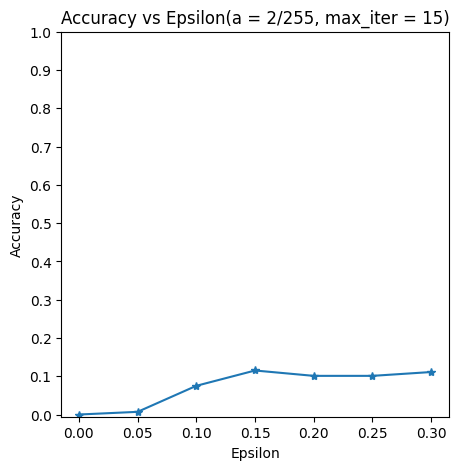

In [10]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon(a = 2/255, max_iter = 15)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

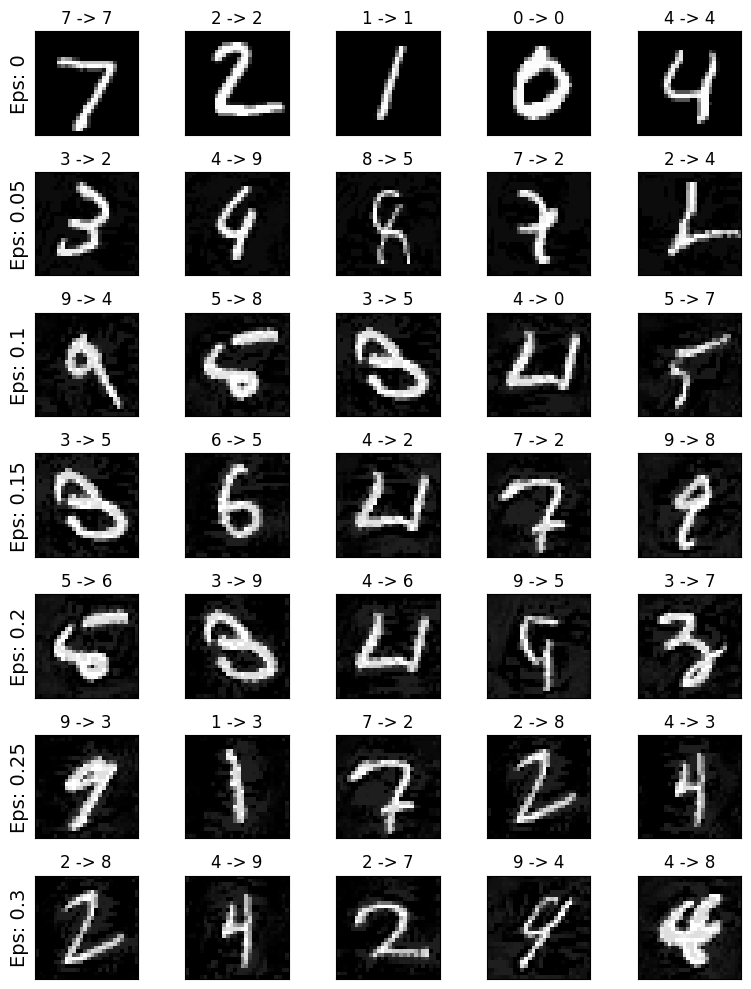

In [12]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex,t = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()